In [62]:
from typing import TypedDict , List
from langgraph.graph import StateGraph , START , END
import requests

In [63]:



class AgentState(TypedDict):
    nums : List[int]
    operator: str
    result : str

In [64]:
def adder(state: AgentState)->AgentState:
    try:
        response = requests.post(
            "http://localhost:8000/add",
            json={"numbers":state['nums']}
        )
        response.raise_for_status()
        result = response.json()["total"]
        state['result'] = state['result'] + f"The sum is {result}"
    except requests.exceptions.RequestException as e:
        state['result'] = state['result'] + f"Error calling addition API: {str(e)}"
    return state


    

In [65]:
def subtractor(state: AgentState)->AgentState:
    try:
        response = requests.post(
            "http://localhost:8000/subtract",
            json={"numbers":state['nums']}
        )
        response.raise_for_status()
        result = response.json()["difference"]
        state['result'] = state['result'] + f"The difference is {result}"
    except requests.exceptions.RequestException as e:
        state['result'] = state['result'] + f"Error calling subtraction API: {str(e)}"
    return state



In [66]:
graph = StateGraph(AgentState)

In [67]:
def routerFunc(state: AgentState)->AgentState:
    if state['operator']=='+':
        return "addPath"
    elif state['operator']=='-':
        return "subtractPath"
    




In [68]:
graph = StateGraph(AgentState)

# 1. Add Workers
graph.add_node("adder", adder)
graph.add_node("subtractor", subtractor)

# 2. Add a Start Node (optional, but good for visualization)
# Here we use a "passthrough" node just to have a centralized starting point before the router
graph.add_node("router", lambda x: x) 

# 3. Start -> Router
graph.add_edge(START, "router")

# 4. Conditional Edges
# Syntax: add_conditional_edges(SourceNode, RouterFunction, MappingDict)
graph.add_conditional_edges(
    "router",        # Where do we start looking?
    routerFunc,      # What logic do we run?
    {
        # Value returned by routerFunc : The Node to go to
        "addPath": "adder", 
        "subtractPath": "subtractor"
    }
)

# 5. Finish
# After adder or subtractor runs, we are done.
graph.add_edge("adder", END)
graph.add_edge("subtractor", END)

app = graph.compile()

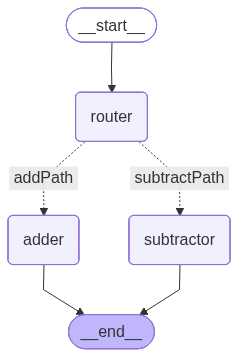

In [69]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [72]:
input_data = {"nums":[10,3],"operator": "+", "result": ""}
result = app.invoke(input_data)
print(f"Result: {result['result']}")

Result: The sum is 13
